In [1]:
%matplotlib inline


Training StreetNet
==============================================
This notebook is modified from [Sasank Chilamkurthy's pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [2]:
# License: BSD

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from os import listdir
import copy
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import IterableDataset
import queue
from os.path import isfile, join

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# cpu takes way to long to train on, so we would really want to use cuda
assert torch.cuda.is_available()

### Loading data

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((29*18,18*18)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((29*20,18*20)), # Should be redundant
        transforms.CenterCrop((29*18,18*18)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# TODO: Set your image directory, should contain 2 folders, "train" and "val"
# Each of these should contain ~86 folders for each country with images inside
data_dir = 'G:\\Desktop\\StreetNet\\split' 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda:0


### Training

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_epoch_losses.append(epoch_loss)
                train_epoch_acces.append(epoch_acc.item())
            else:
                val_epoch_losses.append(epoch_loss)
                val_epoch_acces.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Checkpoint the model
            # TODO: Set your directory
            # torch.save(model, f"G:\\Desktop\\StreetNet\\models\model_{epoch}.pt")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

I found that the performance of resnet50 was 2-3% better than the performance of resnet18.

Ended up training with SGD, with a learning rate of 0.04 and momentum of 0.95. Adam was slightly worse than SGD

In [6]:
model_conv = torchvision.models.resnet50(pretrained=True)

# We only want to train the last parameter
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.04, momentum=0.95)
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [7]:
val_epoch_losses = []
val_epoch_acces = []
train_epoch_losses = []
train_epoch_acces = []

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=75)

Epoch 0/74
----------
train Loss: 5.3758 Acc: 0.0717
val Loss: 5.8471 Acc: 0.0957

Epoch 1/74
----------
train Loss: 5.0439 Acc: 0.1244
val Loss: 5.8397 Acc: 0.1232

Epoch 2/74
----------
train Loss: 4.8072 Acc: 0.1536
val Loss: 4.7648 Acc: 0.1422

Epoch 3/74
----------
train Loss: 4.8909 Acc: 0.1655
val Loss: 5.0230 Acc: 0.1441

Epoch 4/74
----------
train Loss: 4.8242 Acc: 0.1682
val Loss: 5.2119 Acc: 0.1592

Epoch 5/74
----------
train Loss: 4.7192 Acc: 0.1796
val Loss: 5.1260 Acc: 0.1934

Epoch 6/74
----------
train Loss: 4.7300 Acc: 0.1814
val Loss: 5.3678 Acc: 0.1706

Epoch 7/74
----------
train Loss: 4.7242 Acc: 0.1992
val Loss: 5.5944 Acc: 0.1469

Epoch 8/74
----------
train Loss: 4.4028 Acc: 0.2060
val Loss: 4.6633 Acc: 0.1791

Epoch 9/74
----------
train Loss: 4.3403 Acc: 0.2074
val Loss: 5.3217 Acc: 0.1640

Epoch 10/74
----------
train Loss: 2.8629 Acc: 0.3165
val Loss: 3.1636 Acc: 0.2777

Epoch 11/74
----------
train Loss: 2.6331 Acc: 0.3367
val Loss: 3.0946 Acc: 0.2758

Ep

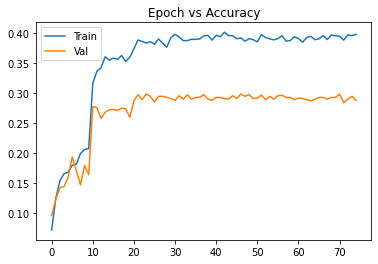

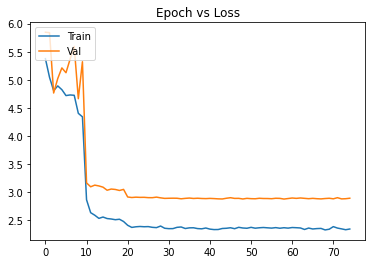

In [8]:
# Graph the loss
plt.plot(train_epoch_acces, label="Train")
plt.plot(val_epoch_acces, label="Val")
plt.title("Epoch vs Accuracy")
plt.legend(loc="upper left")
plt.show()
plt.plot(train_epoch_losses, label="Train")
plt.plot(val_epoch_losses, label="Val")
plt.legend(loc="upper left")
plt.title("Epoch vs Loss")
plt.show()